In [ ]:
INPUT Shape= 224*224 
CUSTOM MADE DataSET

In [2]:
# Importing Tools & Libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, f1_score, PrecisionRecallDisplay

from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

from tensorflow.keras.metrics import Precision, Recall
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [3]:
# Loading Dataset and Define the Path
data_dir = '/kaggle/input/project/DataSet_5(Final)'


In [4]:
# Data Splitting in Validation & Test for training   also applying Data augmentation  

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.7, 1.5),
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of the data for validation+test
)

In [5]:
# Data augmentation is not applied to validation and test data

test_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.5   # Splitting validation + test into 50% validation, 50% test
)

In [6]:
# Training data generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 4669 images belonging to 7 classes.


In [7]:
# Validation data generator
val_generator = test_val_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2915 images belonging to 7 classes.


In [8]:
# Test data generator
test_generator = test_val_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 2918 images belonging to 7 classes.


In [9]:
# Confirmation split Samples

print(f"Training samples: {len(train_generator.filenames)}")
print(f"Validation samples: {len(val_generator.filenames)}")
print(f"Test samples: {len(test_generator.filenames)}")

Training samples: 4669
Validation samples: 2915
Test samples: 2918


In [10]:
# Loading vgg16 model Also Fine-Tuning the Fully-connected Layer

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(460, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(56, activation='relu')(x)
x = Dense(188, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    # Define the optimizer with a custom learning rate
    custom_learning_rate = 0.0003102
    optimizer = Adam(learning_rate=custom_learning_rate)

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 460)            │    11,540,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 460)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │        25,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 188)            │        10,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,32

 Total params: 26,293,483 (100.30 MB)

 Trainable params: 11,578,795 (44.17 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
history_vgg16 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    epochs=20
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/145 ━━━━━━━━━━━━━━━━━━━━ 1:36:19 40s/step - accuracy: 0.0938 - loss: 1.9736

I0000 00:00:1718749678.615365     782 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718749678.636318     782 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 68/145 ━━━━━━━━━━━━━━━━━━━━ 1:12 936ms/step - accuracy: 0.3724 - loss: 1.7192

W0000 00:00:1718749741.347709     782 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.4522 - loss: 1.4990

W0000 00:00:1718749772.864450     783 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/145 ━━━━━━━━━━━━━━━━━━━━ 147s 739ms/step - accuracy: 0.4530 - loss: 1.4969 - val_accuracy: 0.8053 - val_loss: 0.5639
Epoch 2/20
  1/145 ━━━━━━━━━━━━━━━━━━━━ 19s 137ms/step - accuracy: 0.6875 - loss: 0.8225

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


145/145 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6875 - loss: 0.8225 - val_accuracy: 1.0000 - val_loss: 0.0870
Epoch 3/20


W0000 00:00:1718749791.389796     781 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


145/145 ━━━━━━━━━━━━━━━━━━━━ 76s 501ms/step - accuracy: 0.6943 - loss: 0.8470 - val_accuracy: 0.8420 - val_loss: 0.4409
Epoch 4/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - accuracy: 0.8125 - loss: 0.6055 - val_accuracy: 1.0000 - val_loss: 0.4809
Epoch 5/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 76s 501ms/step - accuracy: 0.7484 - loss: 0.7260 - val_accuracy: 0.8486 - val_loss: 0.4017
Epoch 6/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - accuracy: 0.8750 - loss: 0.3907 - val_accuracy: 1.0000 - val_loss: 0.1181
Epoch 7/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 76s 501ms/step - accuracy: 0.7448 - loss: 0.7002 - val_accuracy: 0.8595 - val_loss: 0.4094
Epoch 8/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - accuracy: 0.8750 - loss: 0.4615 - val_accuracy: 1.0000 - val_loss: 0.1828
Epoch 9/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 80s 533ms/step - accuracy: 0.7705 - loss: 0.6457 - val_accuracy: 0.8685 - val_loss: 0.3882
Epoch 10/20
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step - accuracy: 0.7188 - loss: 0.9453 - val_ac

In [14]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.8316 - loss: 0.4655
Test loss: 0.43951573967933655
Test accuracy: 0.838598906993866


In [15]:
def plot_history(history, title):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
    
    


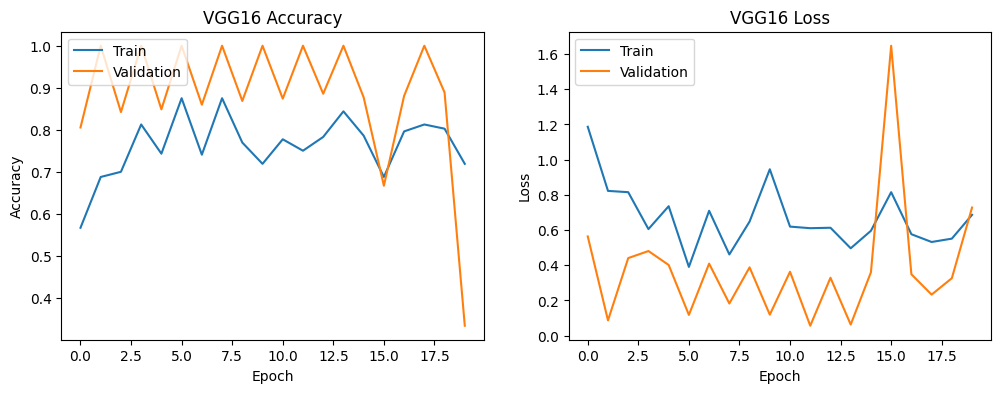

In [16]:
# Plot history for VGG16
plot_history(history_vgg16,'VGG16')

In [17]:
# Printing Classification Report

test_generator.reset()
preds = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step 

W0000 00:00:1718750492.558284     784 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 231ms/step
                 precision    recall  f1-score   support

        Dolphin       0.11      0.10      0.10       391
     Jelly Fish       0.12      0.10      0.11       423
        Octopus       0.10      0.12      0.11       281
    Sea Urchins       0.10      0.09      0.09       290
         Sharks       0.09      0.07      0.08       295
Turtle_Tortoise       0.33      0.37      0.35       952
          Whale       0.11      0.10      0.10       286

       accuracy                           0.19      2918
      macro avg       0.14      0.14      0.14      2918
   weighted avg       0.18      0.19      0.18      2918



W0000 00:00:1718750513.615599     784 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [18]:
# Plotting Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [19]:
# Printing precision, Recall, F1 score

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.177707155762438
Recall: 0.18745716244002741
F1 Score: 0.18174876784199728


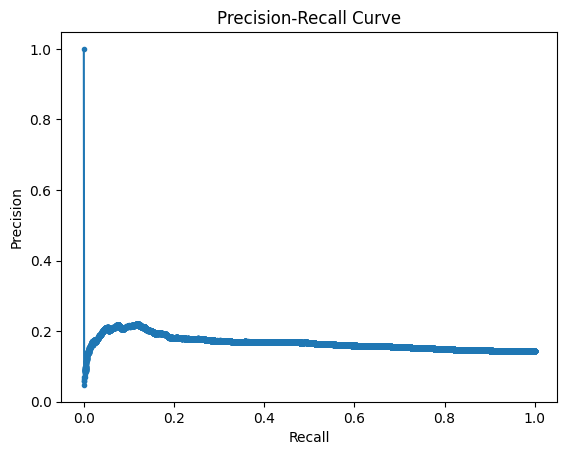

In [20]:
# Plot precision-recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the output for precision-recall curve
y_test_bin = label_binarize(y_true, classes=list(test_generator.class_indices.values()))
y_score_bin = preds

precision_curve, recall_curve, _ = precision_recall_curve(y_test_bin.ravel(), y_score_bin.ravel())

plt.figure()
plt.plot(recall_curve, precision_curve, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [21]:
# Save the VGG16 model
model.save('Vgg16_CDS5(83.85%).h5')